In [116]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont


In [168]:
def textsize(text, font):
    im = Image.new(mode="P", size=(0, 0))
    draw = ImageDraw.Draw(im)
    _, _, width, height = draw.textbbox((0, 0), text=text, font=font)
    return width, height

def add_rotated_text_to_image(image_array: np.ndarray, text: str, position: tuple,font_size, rotation_angle: int = 0, font_path: str = None, text_color: tuple = (255, 255, 255)):
    # Convert numpy array to PIL Image
    image = Image.fromarray(image_array)
    
    # Load a font (default to a basic font if no font path is provided)
    if font_path:
        font = ImageFont.truetype(font_path, font_size)
    else:
        font = ImageFont.load_default(font_size)
    
    # Create the text image to rotate
    text_image = Image.new('RGBA', textsize(text, font=font), (255, 255, 255, 0))
    text_draw = ImageDraw.Draw(text_image)
    text_draw.text((0, 0), text, font=font, fill=text_color)
    
    # Rotate the text image
    rotated_text_image = text_image.rotate(rotation_angle, expand=1)
    
    # Paste the rotated text image onto the original image
    image.paste(rotated_text_image, position, rotated_text_image)
    
    # Convert back to numpy array if needed
    result_image_array = np.array(image)
    
    return result_image_array

def add_text(img, text, pos, rotation_angle=0, font_size=20):
    return add_rotated_text_to_image(img, text, pos, font_size, rotation_angle=rotation_angle, text_color=(0, 0, 0))


(1452, 1842, 3) (1392, 1782, 3)


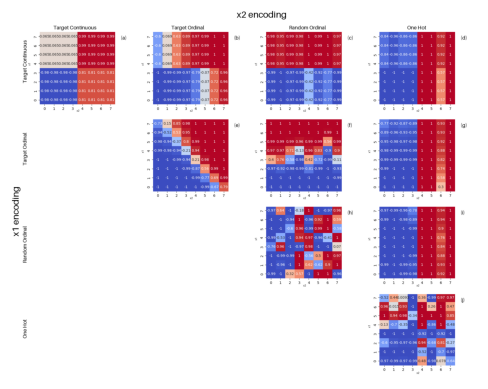

In [215]:
def convert_image(input_file):
    name = input_file
    # Load the original image
    image = cv2.imread(f'{name}.png')

    # Convert image from BGR to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Assuming the image is divided into 4x4 grid of heatmaps
    rows, cols = 4, 4
    height, width, _ = image_rgb.shape
    ho = 20
    sub_height, sub_width = (height - ho) // rows, width // cols

    # Create a list to hold the individual heatmaps
    heatmaps = []

    # Split the image into 16 smaller heatmaps
    for i in range(rows):
        for j in range(cols):
            # Extract the individual heatmap
            sub_image = image_rgb[i*sub_height:(i+1)*sub_height, j*sub_width:(j+1)*sub_width]
            heatmaps.append((i,j,sub_image))
            
            
    legend = None
    counter = 0
    letters = [chr(x) for x in range(97,97+26)]

    # Function to mask the lower triangle
    fontFace = cv2.FONT_HERSHEY_SIMPLEX
    color = (0, 0, 0)
    white = 255

    def mask_lower_triangle(image, i, j):
        # remove heading and legend
        heading_height = 30
        bottom_height = -5
        feature_label_width = 30
        legend_width = -74
        
        image[:heading_height,:,:] = white
        image[bottom_height:,:,:] = white
        image[:,:feature_label_width,:] = white
        
        nonlocal legend
        legend = image[:,legend_width:,:]
        image[:,legend_width:,:] = white
        
        h,w,_ = image.shape
        
        
        if i <= j:
            nonlocal counter
            letter = letters[counter]
            counter += 1
            
            # image = cv2.putText(img=image, text=f"({letter})", org = (w-70,40), fontFace=fontFace, fontScale=0.5, color=color)
            image = add_text(image, f"({letter})", (w-70,40))
            image = add_text(image, "x2", (w // 2 - 20, h-10), font_size=10)
            image = add_text(image, "x1", (10, h // 2 - 20), font_size=10, rotation_angle=90)
            return image
        
        image[:, :, :] = white
        
        return image

    # Apply the mask to each heatmap
    masked_heatmaps = [mask_lower_triangle(hm, i, j) for (i,j,hm) in heatmaps]

    # Recombine the masked heatmaps into a new 4x4 grid image
    combined_image = np.ones_like(image_rgb) * 255
    for i in range(rows):
        for j in range(cols):
            combined_image[i*sub_height:(i+1)*sub_height, j*sub_width:(j+1)*sub_width] = masked_heatmaps[i*cols + j]

    def draw_grid(img, grid_shape, color=(0, 255, 0), thickness=1):
        h, w, _ = img.shape
        rows, cols = grid_shape
        dy, dx = (h - ho) / rows, w / cols

        # draw vertical lines
        for i in range(cols):
            x = int(round(dx * (i+1)))
            cv2.line(img, (x, 0), (x, h), color=color, thickness=thickness)

        # draw horizontal lines
        # for y in np.linspace(start=dy, stop=h-dy, num=rows-1):
        for j in range(rows):
            y = int(round(dy * (j+1)))
            cv2.line(img, (0, y), (w, y), color=color, thickness=thickness)

        return img

    # combined_image = draw_grid(combined_image, (4,4))

    # put column headers
    start_x = 170
    start_y = 120
    dx = 1.15 * (width - start_x) / cols
    dy = 1.15 * (height - start_y) / rows
    labels = ["Target Continuous", "Target Ordinal", "Random Ordinal", "One Hot"]

    # shift everything down
    s = 60
    so = combined_image.shape
    new_c_image = np.ones((so[0] + s, so[1] + s, so[2]), dtype=combined_image.dtype) * white
    new_c_image[s:,s:,:] = combined_image[:,:,:]
    print(new_c_image.shape, combined_image.shape)
    combined_image = new_c_image
    # combined_image[s:,s:,:] = combined_image[:height-s,:width-s,:]
    # combined_image[:s,:,:] = white
    # combined_image[:,:s,:] = white

    for i, label in enumerate(labels):
        x_offset = int(start_x + dx * i)
        y_offset = int(start_y + dy * i)
        combined_image = add_text(combined_image, label, (x_offset, 60))
        combined_image = add_text(combined_image, label, (45, y_offset), rotation_angle=90)

    # put headers
    # cv2.putText(combined_image, "x_2 encoding", (width // 2, 20), fontFace=fontFace, fontScale=0.8, color=color)
    combined_image = add_text(combined_image, "x2 encoding", (width // 2, 0), font_size=35)
    combined_image = add_text(combined_image, "x1 encoding", (0, height // 2), font_size=35, rotation_angle=90)

    # Display the final image
    plt.imshow(combined_image)
    plt.axis('off')
    # plt.show()

    # Save the final image if needed
    cv2.imwrite(f'{name}_processed.png', cv2.cvtColor(combined_image, cv2.COLOR_RGB2BGR))


convert_image("nn_no_reg")

# todo
- write up about the space chnages and how the encoding affects the space for generalization
- find compelling results for the space changes from the original experiments
- write about each experiment
- 